# Practico 5 (parte 5)

## Visualizar los word embeddings que entrenamos

* [Importación de módulos y librerías](#Importación-de-módulos-y-librerías)
* [Definición de que vamos a mostrar del embedding y como vamos a hacerlo](#Definición-de-que-vamos-a-mostrar-del-embedding-y-como-vamos-a-hacerlo)
* [Embedding Word2Vec (caso 1)](#Embedding-Word2Vec-(caso-1))
* [Embedding Word2Vec (caso 2)](#Embedding-Word2Vec-(caso-2))
* [Embedding Word2Vec (caso 3)](#Embedding-Word2Vec-(caso-3))
* [Embedding Word2Vec (caso 4)](#Embedding-Word2Vec-(caso-4))
* [Embedding Glove (caso 5)](#Embedding-Glove-(caso-5))

## Importación de módulos y librerías

In [1]:
#%matplotlib widget

import warnings
warnings.filterwarnings("ignore")

# Inclusion de librerias y módulos
import os
import logging
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Algunas utilidades
from utiles import bcolors

# Importamos wrod2vec de la lib gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Importamos PCA de sklear
from sklearn.decomposition import PCA

# Importamos logger para tener informacion de estado
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Fijamos el estilo a seaborn
plt.style.use('seaborn')

# Fijamos la semilla del random
np.random.seed(42)

# Establecimos el muestreo del vocabulario
Nsamples = 200

## Definición de que vamos a mostrar del embedding y como vamos a hacerlo

Por cada embeding que tenemos vamos a presentar:

* El nombre del archivo que lo contiene, el cual tiene codificado los hiperparametros como se presento en ejercicio anterior
> YYYYMMDD-hhmmss_model_{size}-{window}-{min_count}-{sg}.bin
> * **size**: (predeterminado 100) El número de dimensiones del embedding, por ej. la longitud del vector denso para representar cada token (palabra).
> * **window**: (predeterminado 5) La distancia máxima entre una palabra de referencia y las palabras alrededor de la palabra de referencia.
> * **min_count**: (predeterminado 5) El recuento mínimo de palabras a considerar al entrenar el modelo; las palabras con una ocurrencia menor que este recuento serán ignoradas.
> * **sg**: (predeterminado 0 o CBOW) El algoritmo de entrenamiento, ya sea CBOW (0) o salto gramo (1).
* El tamaño del vocabulario que maneja 
* Las primeras 50 palabras que posee
* Las últimas 50 palabras que posee
* Un scatter plot de un sub grupo de `Nsamples` palabras del embedding, un conjunto de palabras con connotación positiva y un conjunto de emojis con connotación positiva.

In [2]:
def plot_embeding(modelfile, Nsamples=200, positives=None, emojis=None, useglove=False):
    #############################
    # Cargamos el embedding de preferencia, incluyendo la logica para Glove
    if useglove:
        model =  KeyedVectors.load_word2vec_format(modelfile, binary=False)
    else:
        model = Word2Vec.load(modelfile)
    
    #############################
    # Imprimimos el caso nombre del archivo del embedding, el tamaño del vocabulario
    # las primeras 50 palabras del vocabulario y la últimas 50 palabras del vocabulario
    print(f'{bcolors.HEADER}{modelfile} - Tamaño del vocabulario {len(list(model.wv.vocab))}{bcolors.ENDC}')
    print(f'{bcolors.OKGREEN}Primeras 50 compoentes del vocabulario{bcolors.ENDC}')
    print(f'{bcolors.OKBLUE}{list(model.wv.vocab.keys())[0:50]}{bcolors.ENDC}')
    print(f'{bcolors.OKGREEN}Ultimas 50 compoentes del vocabulario{bcolors.ENDC}')
    print(f'{bcolors.OKBLUE}{list(model.wv.vocab.keys())[-50:]}{bcolors.ENDC}')
    print(f'{bcolors.FAIL}#######################################{bcolors.ENDC}')


    #############################
    # Se genera el embedding de cada palabra del vocabulario
    X = model[model.wv.vocab]
    
    # Se genera el embedding de las palabras con connotación positiva
    if positives: Xp = model[positives]
    
    # Se genera el embedding de los emojis con connotación positiva
    if emojis: Xe = model[emojis]

    # Se hace reducción de dimensionalidad por medio de PCA
    # sobre los embeddings generados
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    if positives: resultp = pca.transform(Xp)
    if emojis: resulte = pca.transform(Xe)


    #############################
    # create a scatter plot of the projection
    index = np.random.choice(range(0, result.shape[0]), Nsamples, replace=False)
    
    # Plot de los embeddings luego de aplicar PCA
    plt.figure(figsize=(10,6))
    p1 = sns.scatterplot(x=result[index, 0], y=result[index, 1], s=40, label='Vocabulario')
    if positives: p2 = sns.scatterplot(x=resultp[:, 0], y=resultp[:, 1], s=80, color='red', label='Palabras positivas')
    if emojis: p3 = sns.scatterplot(x=resulte[:, 0], y=resulte[:, 1], s=80, color='green', label='Emojis positivos')

    words = np.array(list(model.wv.vocab))[index]
    result = result[index,:]
    for i,word in enumerate(words):
        p1.text(result[i,0]+0.1, result[i,1], word,horizontalalignment='left', size='medium', color='black')#, weight='semibold')
    
    if positives:
        for i,word in enumerate(positives):
            p2.text(resultp[i,0]+0.1, resultp[i,1], word,horizontalalignment='left', size='large', color='red')#, weight='semibold')
    
    if emojis:
        for i,word in enumerate(emojis):
            p3.text(resulte[i,0]+0.1, resulte[i,1], word,horizontalalignment='left', size='large', color='green')#, weight='semibold')

    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.title('Word2Vec + PCA', fontsize=14)
    plt.legend(fontsize=14)
    sns.despine()
    plt.show()
#     plt.savefig(modelfile+'.svg')

## Definición de lista de palabras y emojis con connotación positiva

* La variable `positives` contine la lista de palabras asociada a expresiones positivas
* La variable `emojis` contiene los emojis asociados a expresiones positivas

Es necesario destacar que no hemos considerado emoticones en el análisis dado que su extracción se hace compleja en el contexto de este tipo de diálogos que contiene expresiones algebráicas. Si bien no es una tarea imposible de realizar, el factor tiempo no hace posible abordar el tratamiento adecuado.

In [3]:
positives = list()
positives.append('great')
positives.append('excellent')
positives.append('nice')
positives.append('awesome')
positives.append('amazing')
positives.append('fantastic')
positives.append('wonderful')
positives.append('perfect')
positives.append('nailed')
positives.append('brilliant')
positives.append('lovely')
positives.append('superb')
positives.append('beautiful')
positives.append('yupppppp')

emojis = list()
emojis.append(':grinning_face_with_smiling_eyes:')
emojis.append(':smiling_face_with_smiling_eyes:')
emojis.append(':face_with_tears_of_joy:')
emojis.append(':grinning_face:')
emojis.append(':smiling_face_with_sunglasses:')
emojis.append(':smiling_face_with_open_mouth_&_smiling_eyes:')

-------------------
### Embedding Word2Vec (caso 1)

Hiperparámetros:
 
 | size | window | min_count | sg |
 | --- | --- | --- | --- |
 | 100  | 5      | 1         | 0 |

En el presente caso nos intereesa analizar el impacto del hiperparámetro `min_count` en la representación del vocabulario. En primera instancia, esperamos que el vocabulario sea extenso o al menos el mayor de todos los casos que se analizaran en el presente notebook. Esto es así dado que dicho hiperparámetro controla la frecuencia mínima que debe tener una palabra del vocabulario para poder ser contemplada en el proceso de embedding. Dado que `min_count = 1`, todas las palabras son consideradas y el vocabulario del embedding es de 91791 palabras.

Si observamos las 50 últimas palabras que aparecen en la parte final del vocabulario (ordenadas de mayor a menor segun la frecuencia de ocurrencia) la mayoria se corresponden con expresiones matemáticas (ecuaciones) y algunos nombres personales, probablemente pertenecientes al enunciado de un problema de matemáticas.

Si observamos el scatter plot del embedding para aun un sub conjunto de `Nsamples = 1000` palabras podemos identificar en el centro palabras relacionadas a expresiones matemáticas, tecnicismos, nombres personales entre otras. Sin embargo, las palabras y emojis con connotacion positiva se encuentra bien distanciadas del resto. Esto, a su vez teniendo en cuenta que es una proyección bidimensionoal aplicando PCA. Lo que sugiere que en el espacio R$^{100}$ esta separación podria ser mas evidente.

./20201008-140336_model_100-5-1-0.bin - Tamaño del vocabulario 91791
Primeras 50 compoentes del vocabulario
['<url>', 'hey', 'robert', '!', 'welcome', 'yup', '', 'looking', 'problem', "'ve", 'reviewed', 'finding', 'domain', 'square', 'root', 'function', 'let', "'s", 'work', 'together', 'find', 'exactly', "'re", 'stuck', 'tried', '?', 'simplifying', 'wrong', 'okay', 'actually', 'need', 'simplify', 'however', 'would', "n't", 'please', 'show', 'check', '2x√-x+7', 'appreciate', 'seem', 'relevant', 'discuss', 'move', 'tell', 'mean', 'word', '"', 'meant', 'learned']
Ultimas 50 compoentes del vocabulario
['x/-4', 'x/-4>8', '880÷.20', '80÷20=40', 'johnathon', '3÷6=2', '2but', 'hermela', '738', 'karia', '800+.2', 'antonniets', 'utillities', 'bill(which', '.1×5', 'questoin', 'dook', '37.5×.1=', 'netpay', 'pay(880', '44is', '3,75', '47.75', '×3', '143.25', 'naything', 'z+1)^2', 'z+1)(z+1', '2z+1', '16z+8', '8z+12', '8z+6', '2z+3', '2*x+0', '2(0)+(0)-3(0)+4', '-j-6', '-3j+4', 'upyo', '-4x-16', 'y>

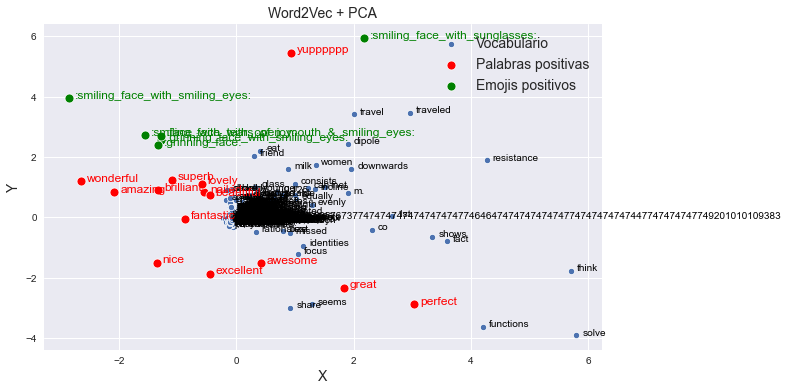

In [4]:
modelfile = os.path.join('.','20201008-140336_model_100-5-1-0.bin')
plot_embeding(modelfile, Nsamples=1000, positives=positives, emojis=emojis)

-------------------
### Embedding Word2Vec (caso 2)

Hiperparámetros:
 
 | size | window | min_count | sg |
 | --- | --- | --- | --- |
 | 100  | 5      | 100       | 0 |
 
En el presente caso nos intereesa analizar el impacto del hiperparámetro `min_count` en la representación del vocabulario. En primera instancia, esperamos que el vocabulario significativamente menor que el recientemente analizado debido a que la frecuencia mínima que debe tener una palabra para poder ser contemplada en el proceso de embedding es `min_count = 100`. Dicho esto, el vocabulario del embedding es de 2591 palabras.

Si observamos las 50 últimas palabras que aparecen en la parte final del vocabulario la mayoria ya no se corresponden con expresiones matemáticas (ecuaciones), ahora aparece palabras mas generales.



Si observamos el scatter plot del embedding par aun un sub conjunto de `Nsamples = 200` palabras podemos identificar nuevamente en el centro un conglomerado palabras pero con significados diferentes. A su vez, las palabras y emojis con connotacion positiva se encuentra mas proximas a este conglomerado. Sin embarogo, las palabras del sub conjunto positivo y de emojis se encuentran muy próximas entre si.

./20201008-140436_model_100-5-100-0.bin - Tamaño del vocabulario 2591
Primeras 50 compoentes del vocabulario
['<url>', 'hey', '!', 'welcome', 'yup', '', 'looking', 'problem', "'ve", 'reviewed', 'finding', 'domain', 'square', 'root', 'function', 'let', "'s", 'work', 'together', 'find', 'exactly', "'re", 'stuck', 'tried', '?', 'simplifying', 'wrong', 'okay', 'actually', 'need', 'simplify', 'however', 'would', "n't", 'please', 'show', 'check', 'appreciate', 'seem', 'discuss', 'move', 'tell', 'mean', 'word', '"', 'meant', 'learned', 'far', 'x', 'good']
Ultimas 50 compoentes del vocabulario
['opens', 'neutrons', 'varma', 'pages', 'x/2', '):', 'electron', 'h+', 'ff', 'collinear', 'eliza', 'terminal', 'amber', 'bonds', 'ticket', 'tickets', 'bonding', 'delta', 'natalie', 'joe', 'breanna', 'f(1', 'molecule', 'pizza', 'matrices', 'oscar', 'wavelength', 'valence', 'slices', 'mackenzie', 'definite', 'yeap', 'index', 'riley', 'dipole', 'shinde', 'candaza', 'alonzo', 'okaye', 'dora', 'vavilakolanu',

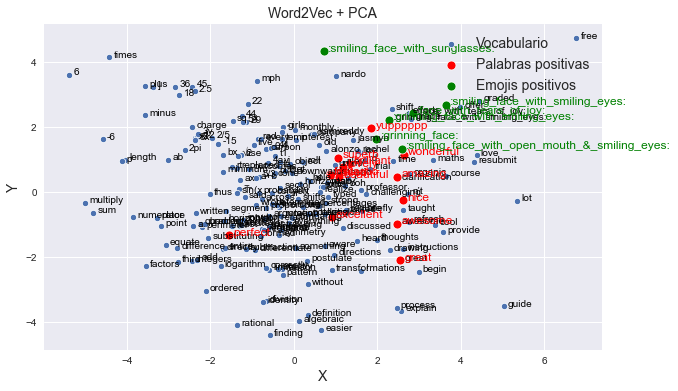

In [5]:
modelfile = os.path.join('.','20201008-140436_model_100-5-100-0.bin')
plot_embeding(modelfile, Nsamples=Nsamples, positives=positives, emojis=emojis)

-------------------
### Embedding Word2Vec (caso 3)

Hiperparámetros:
 
 | size | window | min_count | sg |
 | --- | --- | --- | --- |
 | 100  | 5      | 300       | 0 |


En el presente caso reduciremos el tamaño del vocabulario mediante el hiperparámetro `min_count = 300`. En primera instancia observamos que las palabras y emojis:

* nailed
* lovely
* beautiful
* :grinning_face_with_smiling_eyes:
* :grinning_face_with_smiling_eyes:
* :grinning_face:

quedan fuera del focabulario del embedding y por consiguiente las removemos. Dicho esto, el vocabulario del embedding es de 1400 palabras.

Si observamos el scatter plot del embedding para aun un sub conjunto de `Nsamples = 200` palabras podemos identificar nuevamente en el centro un conglomerado palabras pero con significados diferentes. A su vez, las palabras y emojis con connotacion positiva se encuentra mas distanciadas de este conglomeradoy se encuentran muy próximas entre si.

./20201008-140513_model_100-5-300-0.bin - Tamaño del vocabulario 1400
Primeras 50 compoentes del vocabulario
['<url>', 'hey', '!', 'welcome', 'yup', '', 'looking', 'problem', "'ve", 'reviewed', 'finding', 'domain', 'square', 'root', 'function', 'let', "'s", 'work', 'together', 'find', 'exactly', "'re", 'stuck', 'tried', '?', 'simplifying', 'wrong', 'okay', 'actually', 'need', 'simplify', 'however', 'would', "n't", 'please', 'show', 'check', 'appreciate', 'seem', 'discuss', 'move', 'tell', 'mean', 'word', '"', 'meant', 'learned', 'far', 'x', 'good']
Ultimas 50 compoentes del vocabulario
['leslie', 'block', 'forces', 'nguyen', 'covered', 'matrix', 'conjugate', 'radians', 'dy', 'dx', 'week', 'du', 'voltage', 'ms', 'charge', 'rt', 'bond', 'level', ':raising_hands:', 'reflection', 'anna', 'alexander', '…', 'nardo', 'mahato', 'ms.', ':folded_hands:', 'yupppppp', 'tips', 'dt', 'usha', 'sharma', ':smiling_face_with_sunglasses:', '¡', 'di', ':camera:', 'raman', 'pi/2', 'xymines', 'naw', 'woohoo

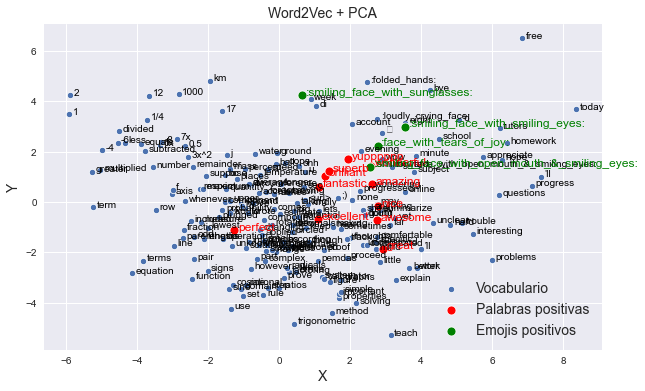

In [6]:
positives = list()
positives.append('great')
positives.append('excellent')
positives.append('nice')
positives.append('awesome')
positives.append('amazing')
positives.append('fantastic')
positives.append('wonderful')
positives.append('perfect')
# positives.append('nailed')
positives.append('brilliant')
# positives.append('lovely')
positives.append('superb')
# positives.append('beautiful')
positives.append('yupppppp')

emojis = list()
# emojis.append(':grinning_face_with_smiling_eyes:')
emojis.append(':smiling_face_with_smiling_eyes:')
emojis.append(':face_with_tears_of_joy:')
# emojis.append(':grinning_face:')
emojis.append(':smiling_face_with_sunglasses:')
emojis.append(':smiling_face_with_open_mouth_&_smiling_eyes:')

modelfile = os.path.join('.','20201008-140513_model_100-5-300-0.bin')
plot_embeding(modelfile, Nsamples=Nsamples, positives=positives, emojis=emojis)

-------------------
### Embedding Word2Vec (caso 4)

Hiperparámetros:
 
 | size | window | min_count | sg |
 | --- | --- | --- | --- |
 | 100  | 1      | 300       | 0 |


En el presente caso continuamos reducirendo el tamaño del vocabulario mediante el hiperparámetro `min_count = 300` y conjuntamente reducimos la ventana de palabras sobre la cual trabaja el algoritmo `window = 1`. Al igual que en el caos 3, las siguientes palabras y emojis:

* nailed
* lovely
* beautiful
* :grinning_face_with_smiling_eyes:
* :grinning_face_with_smiling_eyes:
* :grinning_face:

quedan fuera del focabulario del embedding y por consiguiente fueron removidas. Dicho esto, el vocabulario del embedding es de 1400 palabras.

Si observamos cuidadosamente el scatter plot del embedding para aun un sub conjunto de `Nsamples = 200` palabras podemos apreciar que estas no guardan relación con los sub conjuntos de interés.

./20201008-142337_model_100-1-300-0.bin - Tamaño del vocabulario 1400
Primeras 50 compoentes del vocabulario
['<url>', 'hey', '!', 'welcome', 'yup', '', 'looking', 'problem', "'ve", 'reviewed', 'finding', 'domain', 'square', 'root', 'function', 'let', "'s", 'work', 'together', 'find', 'exactly', "'re", 'stuck', 'tried', '?', 'simplifying', 'wrong', 'okay', 'actually', 'need', 'simplify', 'however', 'would', "n't", 'please', 'show', 'check', 'appreciate', 'seem', 'discuss', 'move', 'tell', 'mean', 'word', '"', 'meant', 'learned', 'far', 'x', 'good']
Ultimas 50 compoentes del vocabulario
['leslie', 'block', 'forces', 'nguyen', 'covered', 'matrix', 'conjugate', 'radians', 'dy', 'dx', 'week', 'du', 'voltage', 'ms', 'charge', 'rt', 'bond', 'level', ':raising_hands:', 'reflection', 'anna', 'alexander', '…', 'nardo', 'mahato', 'ms.', ':folded_hands:', 'yupppppp', 'tips', 'dt', 'usha', 'sharma', ':smiling_face_with_sunglasses:', '¡', 'di', ':camera:', 'raman', 'pi/2', 'xymines', 'naw', 'woohoo

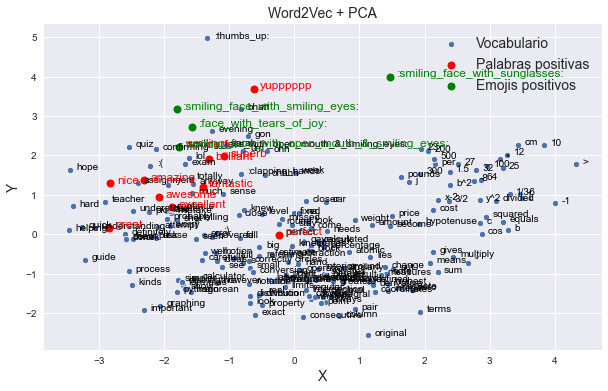

In [7]:
modelfile = os.path.join('.','20201008-142337_model_100-1-300-0.bin')
plot_embeding(modelfile, Nsamples=Nsamples, positives=positives, emojis=emojis)

-------------------
### Embedding Glove (caso 5)

En el caso de Glove, dentro del vocabulario no se encuentra la palabra 'yupppppp' y por tal motivo la removemos del conjunto positivo.

El aspecto que resaltamos aqui es que pese a que el vocabulario con el que fue entrenado el embedding no es el empleado por los casos anteriores, las palabras del grupo positivo se mantienen en un conjunto muy proximas entre ellas. 

In [8]:
positives = list()
positives.append('great')
positives.append('excellent')
positives.append('nice')
positives.append('awesome')
positives.append('amazing')
positives.append('fantastic')
positives.append('wonderful')
positives.append('perfect')
positives.append('nailed')
positives.append('brilliant')
positives.append('lovely')
positives.append('superb')
positives.append('beautiful')
# positives.append('yupppppp')

In [9]:
# glove_input_file = '../glove.6B/glove.6B.100d.txt'
# word2vec_output_file = '../glove.6B/glove.6B.100d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)

../glove.6B/glove.6B.100d.txt.word2vec - Tamaño del vocabulario 400000
Primeras 50 compoentes del vocabulario
['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after']
Ultimas 50 compoentes del vocabulario
['enping', 'suski', 'anangpal', 'singhana', 'weisbuch', 'aronin', 'shuinan', 'jobey', 'bardai', 'passagers', "o'mahonys", 'kiamba', 'grotnes', 'undiplomatically', 'vasović', 'šaper', 'longyou', 'lcia', 'vuoi', 'tavčar', 'fardell', 'nurc', 'sauzal', 'gousmi', 'numbskulls', 'visalakshi', 'lieserl', 'ulundurpet', 'arpita', 'ineta', 'whirlow', 'wanz', 't22', 'slann', 'kunimoto', 'altares', 'cipolletti', 'sherwoods', 'sullana', '29km', 'sigarms', 'katuna', 'aqm', '1.3775', 'corythosaurus', 'chanty', 'kronik', 'rolonda',

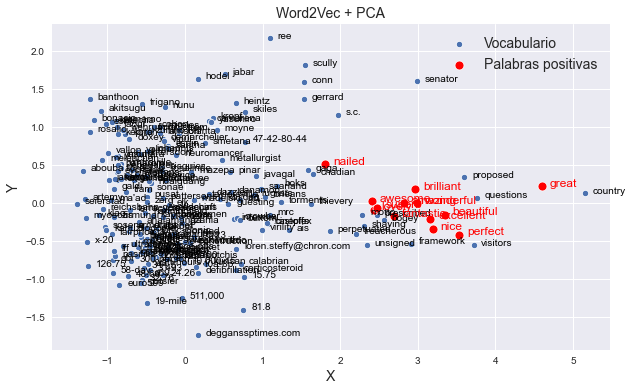

In [10]:
modelfile = os.path.join('..', 'glove.6B', 'glove.6B.100d.txt.word2vec')
plot_embeding(modelfile, Nsamples=Nsamples, positives=positives, emojis=None, useglove=True)